In [4]:
import pandas as pd
import re

# Exemplo de dados carregados diretamente (você precisará substituir pelo caminho correto do arquivo)
with open('data/test.ft.txt', 'r', encoding='utf-8') as f:
    raw_data = f.readlines()

# Função para separar o rótulo e o texto da revisão
def process_review_line(line):
    # Separar rótulo do texto
    match = re.match(r'(__label__\d) (.+)', line)
    if match:
        label = match.group(1)
        review = match.group(2)
        return label, review
    return None, None

# Processar todas as linhas e organizar em listas
labels = []
reviews = []

for line in raw_data:
    label, review = process_review_line(line.strip())
    if label and review:
        labels.append(label)
        reviews.append(review)

# Criar DataFrame organizado
df_test = pd.DataFrame({'label': labels, 'review': reviews})

# Exibir as primeiras linhas do DataFrame
print(df_test.head())

        label                                             review
0  __label__2  Great CD: My lovely Pat has one of the GREAT v...
1  __label__2  One of the best game music soundtracks - for a...
2  __label__1  Batteries died within a year ...: I bought thi...
3  __label__2  works fine, but Maha Energy is better: Check o...
4  __label__2  Great for the non-audiophile: Reviewed quite a...


In [5]:
# Mapeando os rótulos para valores numéricos
df_test['label'] = df_test['label'].map({'__label__1': 1, '__label__2': 2})
df_test.head()

,label,review
0,2,Great CD: My lovely Pat has one of the GREAT v...
1,2,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...: I bought thi...
3,2,"works fine, but Maha Energy is better: Check o..."
4,2,Great for the non-audiophile: Reviewed quite a...


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Baixar pacotes do nltk necessários
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Inicializar lematizador e obter lista de stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Função de tokenização e lematização
def tokenize(text):
    expression = r"\w+"
    match = re.findall(expression, text)
    tokens = [lemmatizer.lemmatize(m.lower()) for m in match if m.lower() not in stop_words]
    return tokens

# Aplicar ao DataFrame
df_test['tokens'] = df_test['review'].apply(tokenize)
print(df_test['tokens'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joaom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\joaom\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\joaom\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0    [great, cd, lovely, pat, one, great, voice, ge...
1    [one, best, game, music, soundtrack, game, rea...
2    [battery, died, within, year, bought, charger,...
3    [work, fine, maha, energy, better, check, maha...
4    [great, non, audiophile, reviewed, quite, bit,...
Name: tokens, dtype: object


In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df_test['review'], df_test['label'], test_size=0.2, random_state=42)

# Definir pipeline com Bag-of-Words e Naive Bayes
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('clf', MultinomialNB())
])

# Treinar o modelo
pipeline.fit(X_train, y_train)

# Avaliar o modelo
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))


c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.84      0.85      0.84     39896
           2       0.85      0.83      0.84     40104

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [8]:
from sklearn.metrics import classification_report, balanced_accuracy_score

# Avaliar o modelo com balanced_accuracy_score
y_pred = pipeline.predict(X_test)
print("Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred))

# Exibir o classification report
print(classification_report(y_test, y_pred))


Balanced Accuracy Score: 0.8427116242305798
              precision    recall  f1-score   support

           1       0.84      0.85      0.84     39896
           2       0.85      0.83      0.84     40104

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000



In [9]:
# Acessar as palavras mais importantes
vectorizer = pipeline.named_steps['vect']
classifier = pipeline.named_steps['clf']

# Obter as palavras do vocabulário
feature_names = vectorizer.get_feature_names_out()

# Obter os log-probabilidades das palavras para cada classe
class_log_prob = classifier.feature_log_prob_

# Identificar as 10 palavras mais importantes para cada classe
top_words_class_1 = class_log_prob[0].argsort()[-10:][::-1]  # Top 10 palavras para __label__1 (negativas)
top_words_class_2 = class_log_prob[1].argsort()[-10:][::-1]  # Top 10 palavras para __label__2 (positivas)

# Exibir as palavras mais importantes
print("Top palavras para __label__1 (negativas):", [feature_names[i] for i in top_words_class_1])
print("Top palavras para __label__2 (positivas):", [feature_names[i] for i in top_words_class_2])


Top palavras para __label__1 (negativas): ['book', 'one', 'like', 'would', 'time', 'get', 'good', 'movie', 'even', 'product']
Top palavras para __label__2 (positivas): ['book', 'great', 'one', 'good', 'like', 'love', 'read', 'time', 'well', 'get']


# Downsampling

c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\t

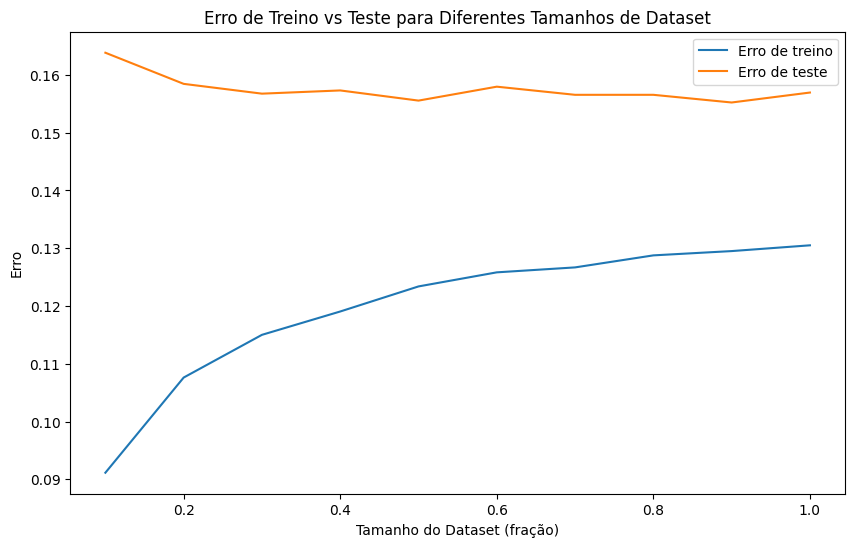

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Função para calcular acurácia em datasets menores
def evaluate_downsampling(pipeline, df_train, sample_sizes):
    train_errors = []
    test_errors = []

    for frac in sample_sizes:
        df_sampled = df_train.sample(frac=frac, random_state=42)
        X_train, X_test, y_train, y_test = train_test_split(df_sampled['review'], df_sampled['label'], test_size=0.2, random_state=42)
        
        # Treinar o modelo com o dataset reduzido
        pipeline.fit(X_train, y_train)
        
        # Acurácia em treino
        train_pred = pipeline.predict(X_train)
        train_acc = balanced_accuracy_score(y_train, train_pred)
        train_errors.append(1 - train_acc)
        
        # Acurácia em teste
        test_pred = pipeline.predict(X_test)
        test_acc = balanced_accuracy_score(y_test, test_pred)
        test_errors.append(1 - test_acc)

    return train_errors, test_errors

# Definir frações do dataset para análise
sample_sizes = np.linspace(0.1, 1.0, 10)

# Avaliar
train_errors, test_errors = evaluate_downsampling(pipeline, df_test, sample_sizes)

# Plotar curvas de erro
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_errors, label='Erro de treino')
plt.plot(sample_sizes, test_errors, label='Erro de teste')
plt.xlabel('Tamanho do Dataset (fração)')
plt.ylabel('Erro')
plt.title('Erro de Treino vs Teste para Diferentes Tamanhos de Dataset')
plt.legend()
plt.show()

# Topic Analysis

In [12]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Usar o CountVectorizer para preparar os dados para LDA
vectorizer = CountVectorizer(tokenizer=tokenize, max_features=10000)
X = vectorizer.fit_transform(df_test['review'])

# Treinar LDA para encontrar 10 tópicos
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# Exibir os tópicos mais importantes
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Top palavras para o Tópico {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Top palavras para o Tópico 0:
dvd video version quality player disc great set one would
Top palavras para o Tópico 1:
book good read information great one many well author would
Top palavras para o Tópico 2:
movie game film good one like great time bad really
Top palavras para o Tópico 3:
love book great year one child old gift wonderful christmas
Top palavras para o Tópico 4:
cd album song music like one great good sound best
Top palavras para o Tópico 5:
product like great use one water get good dog time
Top palavras para o Tópico 6:
book read story one character like life reading time good
Top palavras para o Tópico 7:
great good use one work well product fit would like
Top palavras para o Tópico 8:
product work one time would amazon get buy problem battery
Top palavras para o Tópico 9:
money one would waste like time buy get bought really


In [13]:
# Classificar documentos em tópicos
doc_topics = lda.transform(X)

# Adicionar uma coluna com o tópico principal de cada documento
df_test['topic'] = doc_topics.argmax(axis=1)

# Criar classificadores separados para cada tópico
topic_classifiers = {}
for topic in range(10):
    topic_data = df_test[df_test['topic'] == topic]
    X_topic_train, X_topic_test, y_topic_train, y_topic_test = train_test_split(topic_data['review'], topic_data['label'], test_size=0.2, random_state=42)
    
    # Pipeline de classificação para cada tópico
    topic_pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('clf', MultinomialNB())
    ])
    
    # Treinar o classificador especializado no tópico
    topic_pipeline.fit(X_topic_train, y_topic_train)
    topic_classifiers[topic] = topic_pipeline

    # Avaliar desempenho
    y_topic_pred = topic_pipeline.predict(X_topic_test)
    print(f"Desempenho para o Tópico {topic}:")
    print(classification_report(y_topic_test, y_topic_pred))


c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 0:
              precision    recall  f1-score   support

           1       0.83      0.89      0.86      2033
           2       0.77      0.66      0.71      1083

    accuracy                           0.81      3116
   macro avg       0.80      0.78      0.78      3116
weighted avg       0.81      0.81      0.81      3116



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 1:
              precision    recall  f1-score   support

           1       0.84      0.85      0.85      3703
           2       0.88      0.88      0.88      4753

    accuracy                           0.87      8456
   macro avg       0.86      0.86      0.86      8456
weighted avg       0.87      0.87      0.87      8456



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 2:
              precision    recall  f1-score   support

           1       0.85      0.88      0.87      4342
           2       0.87      0.84      0.86      4171

    accuracy                           0.86      8513
   macro avg       0.86      0.86      0.86      8513
weighted avg       0.86      0.86      0.86      8513



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 3:
              precision    recall  f1-score   support

           1       0.82      0.37      0.51       502
           2       0.91      0.99      0.95      3321

    accuracy                           0.91      3823
   macro avg       0.87      0.68      0.73      3823
weighted avg       0.90      0.91      0.89      3823



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 4:
              precision    recall  f1-score   support

           1       0.85      0.80      0.82      3867
           2       0.89      0.92      0.90      6702

    accuracy                           0.87     10569
   macro avg       0.87      0.86      0.86     10569
weighted avg       0.87      0.87      0.87     10569



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 5:
              precision    recall  f1-score   support

           1       0.85      0.82      0.83      2653
           2       0.85      0.87      0.86      3017

    accuracy                           0.85      5670
   macro avg       0.85      0.84      0.85      5670
weighted avg       0.85      0.85      0.85      5670



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 6:
              precision    recall  f1-score   support

           1       0.88      0.89      0.88      7113
           2       0.89      0.88      0.88      7243

    accuracy                           0.88     14356
   macro avg       0.88      0.88      0.88     14356
weighted avg       0.88      0.88      0.88     14356



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 7:
              precision    recall  f1-score   support

           1       0.85      0.85      0.85      4643
           2       0.87      0.88      0.88      5622

    accuracy                           0.86     10265
   macro avg       0.86      0.86      0.86     10265
weighted avg       0.86      0.86      0.86     10265



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 8:
              precision    recall  f1-score   support

           1       0.89      0.94      0.92      7550
           2       0.77      0.64      0.70      2303

    accuracy                           0.87      9853
   macro avg       0.83      0.79      0.81      9853
weighted avg       0.87      0.87      0.87      9853



c:\Users\joaom\AppData\Local\Continuum\anaconda3\envs\pfe\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Desempenho para o Tópico 9:
              precision    recall  f1-score   support

           1       0.90      0.91      0.91      3626
           2       0.81      0.80      0.80      1758

    accuracy                           0.87      5384
   macro avg       0.86      0.85      0.85      5384
weighted avg       0.87      0.87      0.87      5384

